In [1]:
# Dependencies
import numpy as np
import pandas as pd

In [2]:
from sqlalchemy import create_engine
from hold import connection_string

In [3]:
engine = create_engine(f'{connection_string}', encoding='iso-8859-1', connect_args={'connect_timeout': 10})

In [4]:
gtdDF = pd.read_sql_table('global_terrorism', con= engine)

In [5]:
casualties = gtdDF['nkill'] + gtdDF['nwound']
casualties.sum()

554384.0

In [6]:
gtdDF['casualties'] = gtdDF['nkill'] + gtdDF['nwound']
gtdDF.head()

,iyear,imonth,iday,date,country_txt,region_txt,provstate,city,latitude,longitude,...,weaptype1_txt,weapsubtype1_txt,weaptype2_txt,weapsubtype2_txt,kidhijcountry,ransom,nkill,nwound,index1,casualties
0,2000,1,1,2000-01-01,Namibia,Sub-Saharan Africa,Kavango,Muitjiku,-17.91,19.99,...,Firearms,Unknown Gun Type,None,None,None,NaN,0.0,7.0,1.0,7.0
1,2000,1,1,2000-01-01,Namibia,Sub-Saharan Africa,Kavango,Muitjiku,-17.91,19.99,...,Firearms,Unknown Gun Type,None,None,None,0.0,0.0,7.0,2.0,7.0
2,2000,1,1,2000-01-01,India,South Asia,Jammu and Kashmir,Udhampur,32.93,75.14,...,Firearms,Unknown Gun Type,None,None,None,NaN,1.0,2.0,3.0,3.0
3,2000,1,1,2000-01-01,Kosovo,Eastern Europe,Kosovo (Province),Peje,42.66,20.31,...,Explosives/Bombs/Dynamite,Unknown Explosive Type,None,None,None,NaN,0.0,1.0,4.0,1.0
4,2000,1,1,2000-01-01,Somalia,Sub-Saharan Africa,Banaadir,Mogadishu,2.11,45.39,...,Firearms,Unknown Gun Type,None,None,None,NaN,6.0,10.0,5.0,16.0


In [7]:
RegionCasualtiesDF = gtdDF[['index1','region_txt','casualties']]
RegionCasualtiesDF = RegionCasualtiesDF.reset_index()
RegionCasualtiesDF.head()

,index,index1,region_txt,casualties
0,0,1.0,Sub-Saharan Africa,7.0
1,1,2.0,Sub-Saharan Africa,7.0
2,2,3.0,South Asia,3.0
3,3,4.0,Eastern Europe,1.0
4,4,5.0,Sub-Saharan Africa,16.0


In [8]:
# Multiply the dummies by the casualties so that the regression works for casualties
RegionCasualties2DF = pd.get_dummies(RegionCasualtiesDF['region_txt']).mul(RegionCasualtiesDF['casualties'],0)
RegionCasualties2DF = RegionCasualties2DF.reset_index()
RegionCasualties2DF.head()

,index,Australasia & Oceania,Central America & Caribbean,Central Asia,East Asia,Eastern Europe,Middle East & North Africa,North America,South America,South Asia,Southeast Asia,Sub-Saharan Africa,Western Europe
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
3,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0


In [9]:
RegionCasualtiesMergeDF = result = pd.merge(RegionCasualties2DF,RegionCasualtiesDF[['index','region_txt','casualties']],on='index')
RegionCasualtiesMergeDF.head()

,index,Australasia & Oceania,Central America & Caribbean,Central Asia,East Asia,Eastern Europe,Middle East & North Africa,North America,South America,South Asia,Southeast Asia,Sub-Saharan Africa,Western Europe,region_txt,casualties
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,Sub-Saharan Africa,7.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,Sub-Saharan Africa,7.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,South Asia,3.0
3,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Eastern Europe,1.0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0,Sub-Saharan Africa,16.0


In [10]:
# Assign X (data) and y (target)
X = RegionCasualtiesMergeDF.drop(["index","region_txt",'casualties'], axis=1)
y = RegionCasualtiesMergeDF["region_txt"]
feature_names = X.columns

print(X.shape, y.shape)

(92700, 12) (92700,)


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=1, stratify=y)
X_scaler = StandardScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Step 1: Label-encode data set
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
encoded_y_train = label_encoder.transform(y_train)
encoded_y_test = label_encoder.transform(y_test)

# Step 2: Convert encoded labels to one-hot-encoding
y_train_categorical = to_categorical(encoded_y_train)
y_test_categorical = to_categorical(encoded_y_test)

C:\Users\kruiz\Anaconda3\envs\PythonData\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [12]:
from keras.models import Sequential
from keras.layers import Dense

# Create model and add layers
model = Sequential()
model.add(Dense(units=128, activation='relu', input_dim=12))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=12, activation='softmax'))

In [13]:
# Compile and fit the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(
    X_train_scaled,
    y_train_categorical,
    epochs=20,
    shuffle=True,
    verbose=2
)

Epoch 1/20
 - 3s - loss: 0.6470 - acc: 0.7776
Epoch 2/20
 - 2s - loss: 0.5779 - acc: 0.7868
Epoch 3/20
 - 2s - loss: 0.5732 - acc: 0.7884
Epoch 4/20
 - 2s - loss: 0.5688 - acc: 0.7909
Epoch 5/20
 - 2s - loss: 0.5682 - acc: 0.7897
Epoch 6/20
 - 2s - loss: 0.5679 - acc: 0.7893
Epoch 7/20
 - 2s - loss: 0.5639 - acc: 0.7903
Epoch 8/20
 - 2s - loss: 0.5612 - acc: 0.7936
Epoch 9/20
 - 2s - loss: 0.5600 - acc: 0.7952
Epoch 10/20
 - 2s - loss: 0.5593 - acc: 0.7962
Epoch 11/20
 - 2s - loss: 0.5589 - acc: 0.7961
Epoch 12/20
 - 2s - loss: 0.5585 - acc: 0.7963
Epoch 13/20
 - 2s - loss: 0.5584 - acc: 0.7963
Epoch 14/20
 - 2s - loss: 0.5583 - acc: 0.7960
Epoch 15/20
 - 2s - loss: 0.5582 - acc: 0.7963
Epoch 16/20
 - 2s - loss: 0.5581 - acc: 0.7963
Epoch 17/20
 - 2s - loss: 0.5581 - acc: 0.7960
Epoch 18/20
 - 2s - loss: 0.5582 - acc: 0.7962
Epoch 19/20
 - 2s - loss: 0.5581 - acc: 0.7962
Epoch 20/20
 - 2s - loss: 0.5580 - acc: 0.7963


In [14]:
model_loss, model_accuracy = model.evaluate(
    X_test_scaled, y_test_categorical, verbose=2)
print(
    f"Normal Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")

Normal Neural Network - Loss: 0.5543658397215727, Accuracy: 0.7979719525363453


In [15]:
encoded_predictions = model.predict_classes(X_test_scaled[:12])
prediction_labels = label_encoder.inverse_transform(encoded_predictions)

C:\Users\kruiz\Anaconda3\envs\PythonData\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [16]:
print(f"Predicted classes: {prediction_labels}")
print(f"Actual Labels: {list(y_test[:20])}")

Predicted classes: ['Middle East & North Africa' 'South Asia' 'Middle East & North Africa'
 'Middle East & North Africa' 'Sub-Saharan Africa'
 'Middle East & North Africa' 'Middle East & North Africa'
 'Middle East & North Africa' 'Eastern Europe' 'South Asia' 'South Asia'
 'Southeast Asia']
Actual Labels: ['Middle East & North Africa', 'Middle East & North Africa', 'Middle East & North Africa', 'Middle East & North Africa', 'Sub-Saharan Africa', 'Middle East & North Africa', 'Middle East & North Africa', 'Middle East & North Africa', 'Eastern Europe', 'South America', 'South Asia', 'Southeast Asia', 'South Asia', 'Sub-Saharan Africa', 'South Asia', 'Middle East & North Africa', 'South Asia', 'Southeast Asia', 'Sub-Saharan Africa', 'South Asia']


In [17]:
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot
model = XGBClassifier()
model.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [18]:
sorted(zip(model.feature_importances_, feature_names), reverse=True)

[(0.19438766, 'Sub-Saharan Africa'),
 (0.17019035, 'Southeast Asia'),
 (0.14419489, 'Middle East & North Africa'),
 (0.12628934, 'Eastern Europe'),
 (0.12181826, 'South Asia'),
 (0.103415914, 'South America'),
 (0.06067469, 'Western Europe'),
 (0.02656761, 'North America'),
 (0.022034422, 'Central Asia'),
 (0.019679395, 'East Asia'),
 (0.008934601, 'Central America & Caribbean'),
 (0.0018128887, 'Australasia & Oceania')]

In [19]:
DLCasualtiesRegionDF = pd.DataFrame(sorted(zip(model.feature_importances_, feature_names), reverse=True), 
                               columns = ['Probability', 'Region'])
DLCasualtiesRegionDF

,Probability,Region
0,0.194388,Sub-Saharan Africa
1,0.170190,Southeast Asia
2,0.144195,Middle East & North Africa
3,0.126289,Eastern Europe
4,0.121818,South Asia
5,0.103416,South America
6,0.060675,Western Europe
7,0.026568,North America
8,0.022034,Central Asia
9,0.019679,East Asia


In [20]:
sorted(zip(model.feature_importances_, feature_names), reverse = True)
# Fit model using each importance as a threshold
from numpy import sort
thresholds = sort(model.feature_importances_)
print(thresholds)

[0.00181289 0.0089346  0.0196794  0.02203442 0.02656761 0.06067469
 0.10341591 0.12181826 0.12628934 0.14419489 0.17019035 0.19438766]


In [21]:
pies = DLCasualtiesRegionDF['Region'].head(8)
pie_slices = DLCasualtiesRegionDF['Probability'].head(8)
colors = ["lightskyblue","orange","pink","yellowgreen","lightcoral","silver","yellow",
          "lightgreen","wheat","khaki"]
explode = (0.1,0,0,0,0,0,0,0)

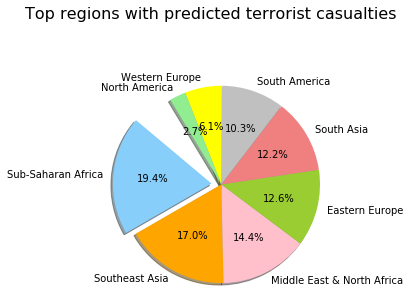

In [22]:
# Tell matplotlib to create a pie chart based upon the above data
pyplot.pie(pie_slices, explode=explode, labels=pies, colors=colors, 
        autopct="%1.1f%%", shadow=True, startangle=140)
# Create axes which are equal so we have a perfect circle
pyplot.axis("equal")
# Save an image of our chart and print the final product to the screen

pyplot.savefig("../GTA/front_end/static/front_end/assets/visualizations/ML13_Region_Casualties_Pie_DL")
pyplot.suptitle('Top regions with predicted terrorist casualties', size=16, y=1.12) 
pyplot.show()

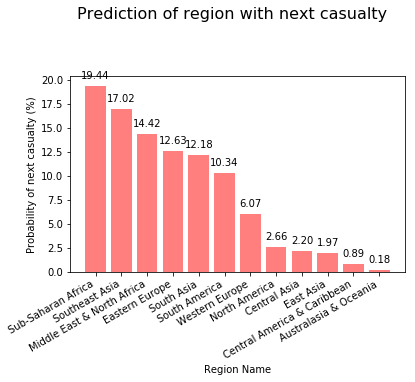

In [23]:
y_axis = DLCasualtiesRegionDF['Probability']*100
x_axis = DLCasualtiesRegionDF['Region']
fig, ax = pyplot.subplots()
# plot
ax.bar(x_axis, y_axis, color='r', alpha=0.5, align="center")

# Make space for and rotate the x-axis tick labels
fig.autofmt_xdate()

# Labels for x and y axes
pyplot.xlabel("Region Name")
pyplot.ylabel("Probability of next casualty (%)")

# Show the values of each probability on plot
def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.
    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.2f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.

# Call the function above. All the magic happens there.
add_value_labels(ax)

# Save an image of our chart and print the final product to the screen
pyplot.savefig("../GTA/front_end/static/front_end/assets/visualizations/ML13_Region_Casualties_Bar_DL")
# Title for the chart
pyplot.suptitle('Prediction of region with next casualty', size=16, y=1.12) 
pyplot.show()
